# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import random

In [3]:
random.seed(123)

## Working with Shape File

### Loading Census Tract Shape File¶

In [4]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [5]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

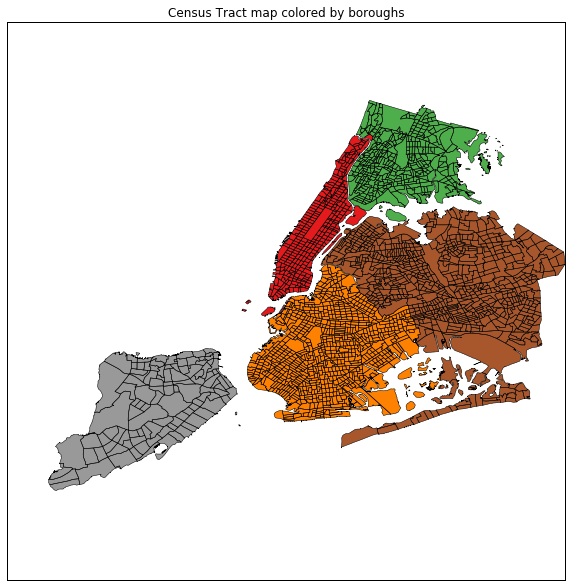

In [6]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#create a color based on boro information
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [7]:
#http://www.socialexplorer.com/ has clean census tract data
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [8]:
ct_data.head()

,BoroCT2010,Geo_NAME,Geo_QName,Geo_FIPS,Geo_SUMLEV,Geo_GEOCOMP,Geo_STATE,Geo_COUNTY,Geo_COUNTYSC,Geo_COUSUB,...,SE_T017_017,SE_T017_018,SE_T017_019,SE_T017_020,SE_T017_021,SE_T017_022,SE_T017_023,SE_T017_024,SE_T017A001,SE_T017A002
BoroCT2010,,,,,,,,,,,,,,,,,,,,,
5000900,5000900,Census Tract 9,"Census Tract 9, Richmond County, New York",36085000900,140,0,36,85,19,NaN,...,32,23,13,12,10,12,11,7,746,50
5012500,5012500,Census Tract 125,"Census Tract 125, Richmond County, New York",36085012500,140,0,36,85,19,NaN,...,50,50,28,33,36,32,42,20,1522,89
5013301,5013301,Census Tract 133.01,"Census Tract 133.01, Richmond County, New York",36085013301,140,0,36,85,19,NaN,...,0,11,6,3,15,4,4,4,303,24
5019700,5019700,Census Tract 197,"Census Tract 197, Richmond County, New York",36085019700,140,0,36,85,19,NaN,...,48,56,36,50,54,32,44,36,1672,97
5002002,5002002,Census Tract 20.02,"Census Tract 20.02, Richmond County, New York",36085002002,140,0,36,85,19,NaN,...,73,126,53,73,114,83,63,63,2562,104


In [9]:
#the indices of ct_data and ct_shape are the same
#in this example, one index was changed from integer to string so that the join could work
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


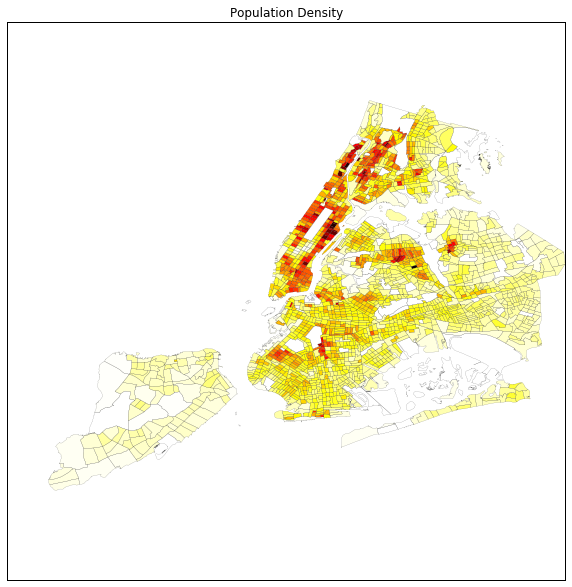

In [10]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [11]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

(-200, 16000)

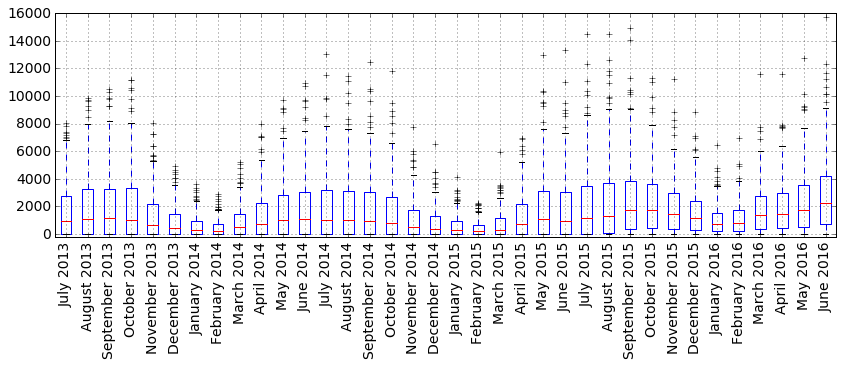

In [12]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

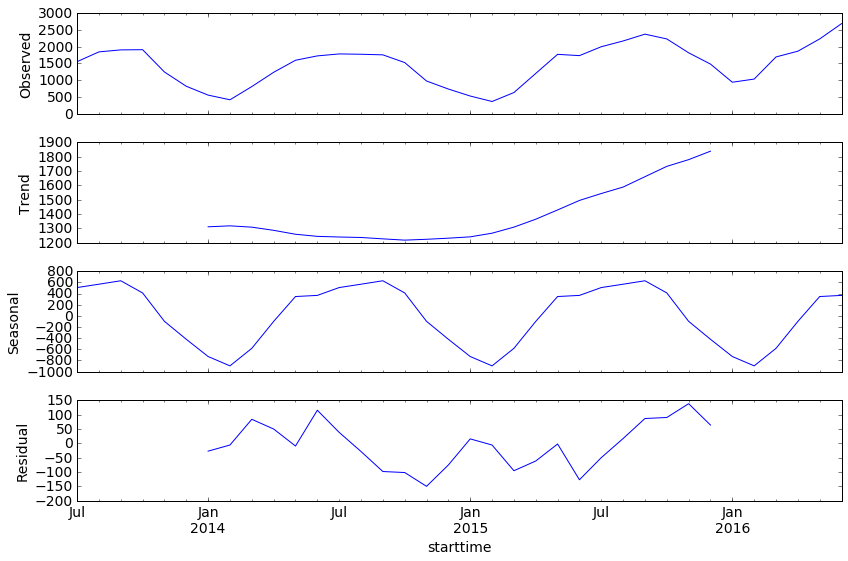

In [13]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()
#residual plots the maximum residual
#statsmodels.tsa picks the best time period to analyze the data
#should dropna() but don't need to here because he already did it

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [14]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [15]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column

#tell the computer that lonlat is a geometry point and do so with the shapely.geometry.Point()
#creating a geometry for each station 
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [16]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [17]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [18]:
df_bike_monthly_.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
July 2013,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
August 2013,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
September 2013,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
October 2013,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
November 2013,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#isolate summer and winter months
df_bike_monthly_reset = df_bike_monthly_.reset_index()
df_bike_monthly_reset.head()

,index,1000,1001,1002,1003,1004,1005,1006,1007,1008,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
0,July 2013,2343,3914,6979,2750,4914,2229,2183,3139,3622,...,0,0,0,0,0,0,0,0,0,0
1,August 2013,2696,4429,9020,3433,6645,2768,2761,3422,4271,...,0,0,0,0,0,0,0,0,0,0
2,September 2013,2878,5258,9814,3739,7837,3206,2747,3590,4618,...,0,0,0,0,0,0,0,0,0,0
3,October 2013,2920,4409,10456,3520,8928,3237,2530,3909,4169,...,0,0,0,0,0,0,0,0,0,0
4,November 2013,1883,2731,6384,2446,5201,2085,1415,2727,3146,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#print(df_bike_monthly_reset.iloc[:,0])

In [21]:
#df_bike_monthly_reset.iloc[5:9]
#df_bike_monthly_reset.iloc[17:21]
#df_bike_monthly_reset.iloc[35]

In [22]:
summer_df = pd.concat([df_bike_monthly_reset.iloc[0:3], df_bike_monthly_reset.iloc[11:15], df_bike_monthly_reset.iloc[23:27]])

In [23]:
summer_df = summer_df.append(df_bike_monthly_reset.iloc[35])

In [24]:
summer_df

,index,1000,1001,1002,1003,1004,1005,1006,1007,1008,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
0,July 2013,2343,3914,6979,2750,4914,2229,2183,3139,3622,...,0,0,0,0,0,0,0,0,0,0
1,August 2013,2696,4429,9020,3433,6645,2768,2761,3422,4271,...,0,0,0,0,0,0,0,0,0,0
2,September 2013,2878,5258,9814,3739,7837,3206,2747,3590,4618,...,0,0,0,0,0,0,0,0,0,0
11,June 2014,2048,3306,9626,3515,7255,2942,1917,3702,3694,...,0,0,0,0,0,0,0,0,0,0
12,July 2014,2252,3216,9825,3509,7014,3224,2195,3732,4042,...,0,0,0,0,0,0,0,0,0,0
13,August 2014,2179,3004,10196,3573,7328,3311,2213,4078,4011,...,0,0,0,0,0,0,0,0,0,0
14,September 2014,2281,3678,10357,3680,7740,3695,2217,4112,3504,...,0,0,0,0,0,0,0,0,0,0
23,June 2015,2309,0,9457,3426,5859,4763,1809,5190,2695,...,0,0,0,0,0,0,0,0,0,0
24,July 2015,2556,3831,10341,3958,6424,5397,2185,5688,4846,...,0,0,0,0,0,0,0,0,0,0
25,August 2015,2640,3799,11801,4288,7031,5417,2470,6306,4583,...,0,0,0,0,0,0,0,0,0,0


In [25]:
winter_df = pd.concat([df_bike_monthly_reset.iloc[5:9], df_bike_monthly_reset.iloc[17:21], df_bike_monthly_reset.iloc[29:33]])

In [26]:
summer_df.index

Int64Index([0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 35], dtype='int64')

In [27]:
summer_df = summer_df.set_index(summer_df['index'])
#summer_df = summer_df.iloc[:,1:]
summer_df = summer_df.drop(['index'], axis=1)

In [28]:
winter_df = winter_df.set_index(winter_df['index'])
winter_df = winter_df.iloc[:,1:]

In [29]:
summer_df = summer_df.dropna()

In [30]:
summer_df

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
index,,,,,,,,,,,,,,,,,,,,,
July 2013,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
August 2013,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
September 2013,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
June 2014,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,0,0,0
July 2014,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,0,0
August 2014,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,0,0
September 2014,2281,3678,10357,3680,7740,3695,2217,4112,3504,2315,...,0,0,0,0,0,0,0,0,0,0
June 2015,2309,0,9457,3426,5859,4763,1809,5190,2695,2116,...,0,0,0,0,0,0,0,0,0,0
July 2015,2556,3831,10341,3958,6424,5397,2185,5688,4846,2743,...,0,0,0,0,0,0,0,0,0,0


In [31]:
winter_df.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
index,,,,,,,,,,,,,,,,,,,,,
December 2013,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
January 2014,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
February 2014,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
March 2014,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0
December 2014,1052,1304,4501,1783,2985,2091,779,2108,1636,878,...,0,0,0,0,0,0,0,0,0,0


In [32]:
### Create average summer and winter rides column from monthly citibike data and add it to the station id which has the geometry

station_id_summer = station_id
station_id_summer['SummerAve'] = summer_df.sum()
station_id_summer.head()

,lat,lon,lonlat,geometry,BoroCT2010,SummerAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,30696
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,45966
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,118837
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,44794
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,82749


In [33]:
station_id_winter = station_id
station_id_winter['WinterAve'] = winter_df.sum()
station_id_winter = station_id_winter.drop(['SummerAve'], axis=1)
station_id_winter.head()

,lat,lon,lonlat,geometry,BoroCT2010,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,13163
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,16113
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,52940
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,19541
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,31319


### Add the monthly average rides to the CT shapefile 

In [34]:
temps=station_id_summer[['SummerAve']]
temps['station_id']=station_id.index
temps.index=station_id['BoroCT2010']
ct_shape_SummerAve=ct_shape.join(temps)
ct_shape_SummerAve.fillna(0,inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


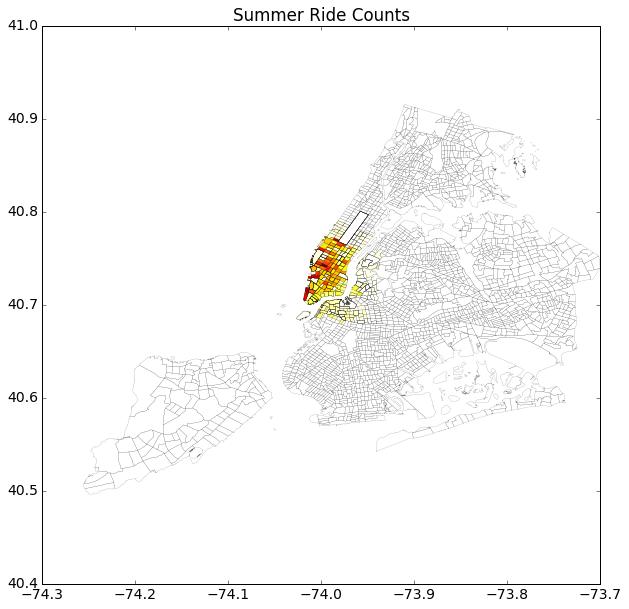

In [35]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_SummerAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

In [36]:
tempw=station_id_winter[['WinterAve']]
tempw['station_id']=station_id.index
tempw.index=station_id['BoroCT2010']
ct_shape_WinterAve=ct_shape.join(tempw)
ct_shape_WinterAve.fillna(0,inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


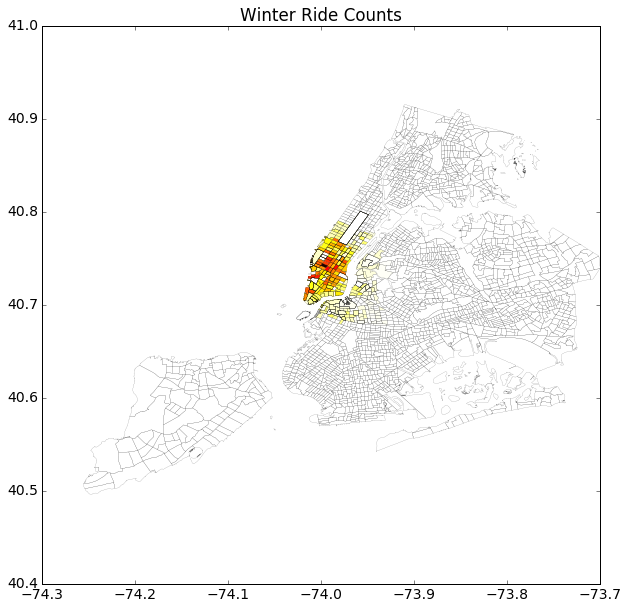

In [37]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_WinterAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

### Removing the CTs that are out of zoom boundries

In [38]:
ct_shape_SummerAve_Zoom=(ct_shape_SummerAve[ct_shape_SummerAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [39]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temps.SummerAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


In [40]:
ct_shape_WinterAve_Zoom=(ct_shape_WinterAve[ct_shape_WinterAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [41]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(tempw.WinterAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

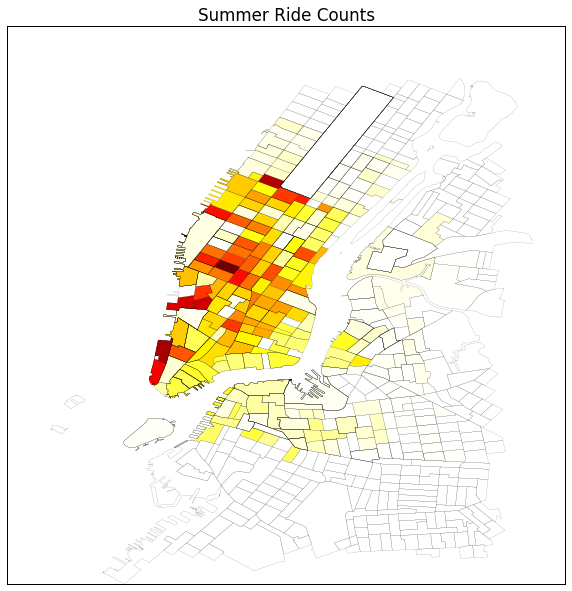

In [42]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_SummerAve_Zoom.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

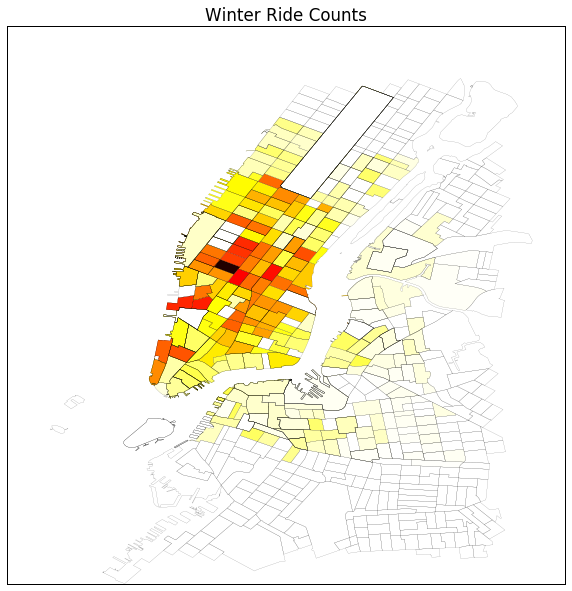

In [43]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_WinterAve_Zoom.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [44]:
path='Output/ct_shape_SummerAve_Zoom.shp'
ct_shape_SummerAve_Zoom.to_file(path)

In [45]:
pathw='Output/ct_shape_WinterAve_Zoom.shp'
ct_shape_WinterAve_Zoom.to_file(pathw)

## Exploratory Geospatial Analysis

In [46]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [47]:
#when using pysal, keep coordinates as lat and long
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


In [48]:
qW_CT_w=ps.queen_from_shapefile(pathw)

('Island id: ', [0])


#### Neighbors of index10

In [49]:
#these are neighbors of index10
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [50]:
qW_CT_w[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [51]:
qW_CT.cardinalities[10]

9

In [52]:
qW_CT_w.cardinalities[10]

9

#### Matrix of Weights

In [53]:
Wmatrix, ids = qW_CT.full()

In [54]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [55]:
Wmatrixw, idsw = qW_CT_w.full()

In [56]:
Wmatrixw

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [57]:
#sum of the row is equal to 1
#island doesn't have any neighbor (Staten Island)
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


In [58]:
qW_CT_w.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [59]:
#spatial lag is the weighted average of the neighbors of your point
#don't consider the position of the point of interest
#for each point, these are the neighbors

SummerRide=ct_shape_SummerAve_Zoom.SummerAve
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

In [60]:
WinterRide=ct_shape_WinterAve_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT_w, WinterRide)

#### Create Quantiles for maping

In [61]:
#breaks up the data into 10 different quantiles
#area under the curve is broken up into 10 even sections
#use quantiles when you don't know the nature of your data
#the first quantile has many more points than the others because there are a lot of zeros

In [62]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    88.000                 2
   88.000 < x[i] <=  1511.625                78
 1511.625 < x[i] <=  3075.000                80
 3075.000 < x[i] <=  7551.400                81
 7551.400 < x[i] <= 11627.857                78
11627.857 < x[i] <= 25693.803                79
25693.803 < x[i] <= 37395.214                80
37395.214 < x[i] <= 43198.655                79
43198.655 < x[i] <= 66036.500                80

In [63]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    55.143                 2
   55.143 < x[i] <=   902.271                78
  902.271 < x[i] <=  2165.333                80
 2165.333 < x[i] <=  3452.913                79
 3452.913 < x[i] <=  5014.083                80
 5014.083 < x[i] <= 11249.113                79
11249.113 < x[i] <= 15205.882                80
15205.882 < x[i] <= 18477.420                79
18477.420 < x[i] <= 29902.786                80

#### Map the monthly rides lag

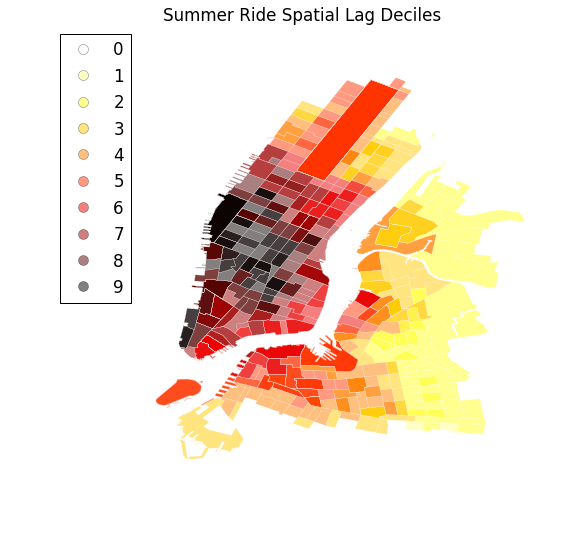

In [64]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_SummerAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")

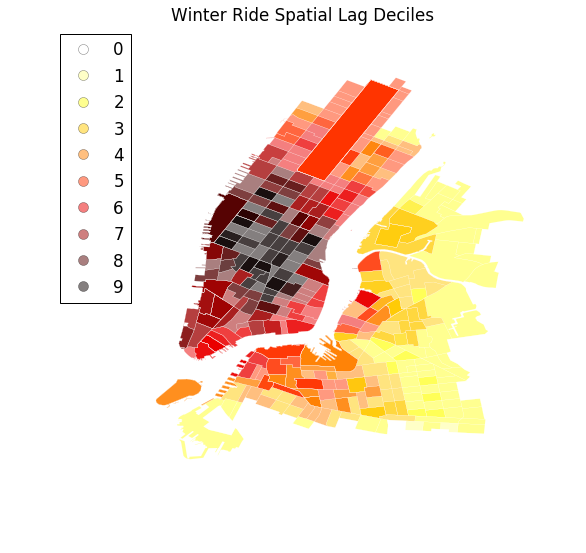

In [65]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation

In [66]:
b,a = np.polyfit(SummerRide, SummerRideLag, 1)
b,a 

(0.64389314312589219, 5682.9310787418444)

In [67]:
bw,aw = np.polyfit(WinterRide, WinterRideLag, 1)
bw,aw 

(0.66189462250696851, 2331.8176412763291)

### Moran Scatterplot

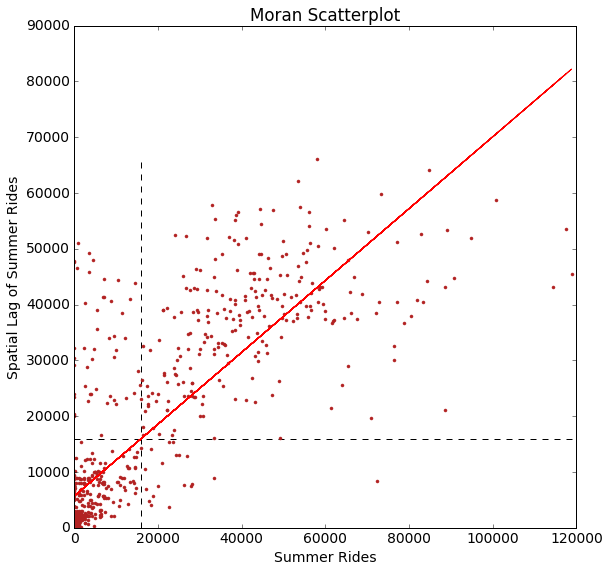

In [68]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

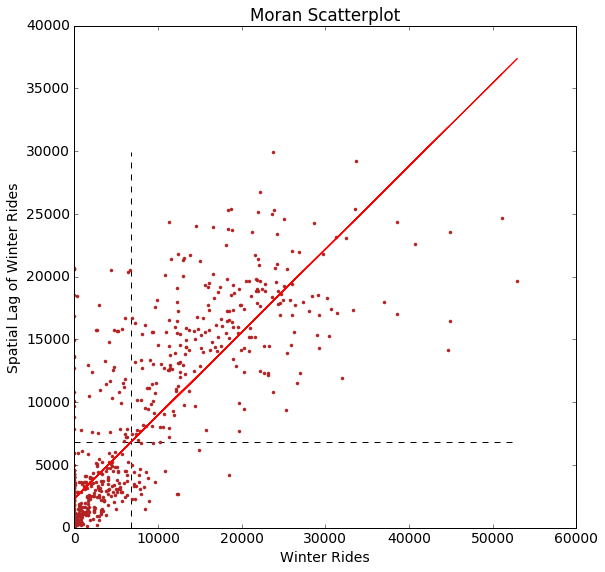

In [69]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, aw + bw*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

### Moran's I

In [70]:
#runs 1000 permutation 
I_SummerRide = ps.Moran(SummerRide, qW_CT)

In [71]:
I_SummerRide.I, I_SummerRide.p_sim

(0.6440694990680973, 0.001)

Thus, the $I$ statistic is $0.644$ for this data, and has a very small $p$ value. 

In [72]:
I_SummerRide.sim[0:10]

array([-0.00274415, -0.04788651,  0.01493095, -0.02311834, -0.01185977,
       -0.00957785, -0.0162307 ,  0.01274754,  0.01562057,  0.00665377])

In [73]:
I_WinterRide = ps.Moran(WinterRide, qW_CT_w)

In [74]:
I_WinterRide.I, I_WinterRide.p_sim

(0.66204419671059411, 0.001)

Thus, the $I$ statistic is $0.662$ for this data, and has a very small $p$ value. 

In [75]:
I_WinterRide.sim[0:10]

array([-0.00913383, -0.01604962,  0.02087506,  0.00576152, -0.00958458,
       -0.01538284,  0.01118911, -0.0066949 ,  0.05952941, -0.00379787])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [76]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

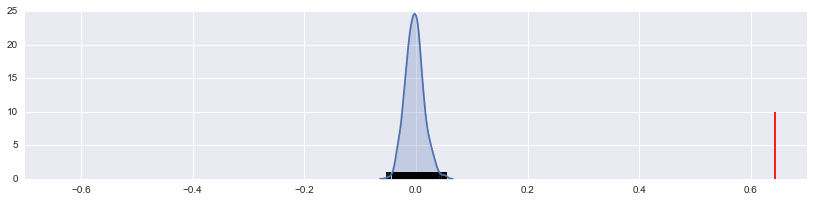

In [77]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

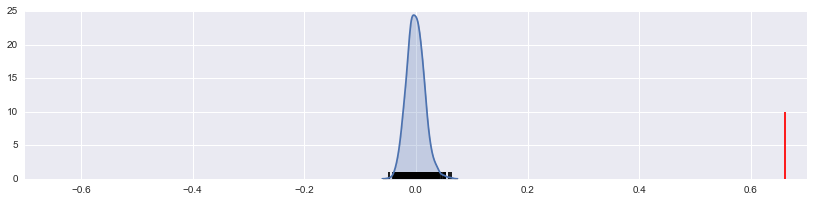

In [78]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

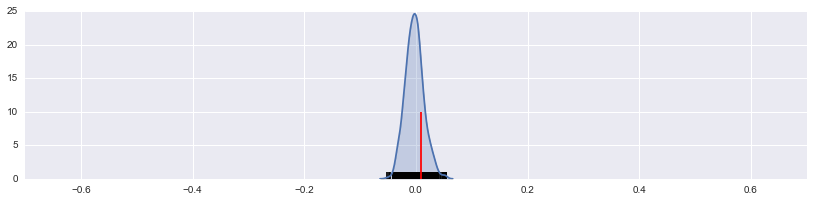

In [79]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

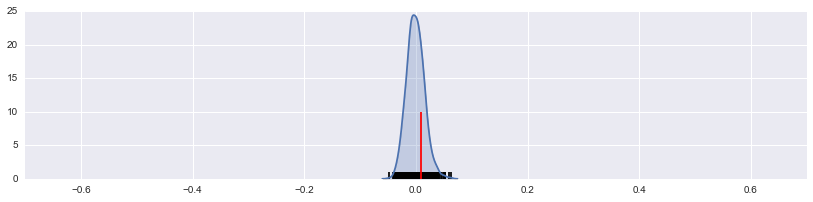

In [80]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [81]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)

//anaconda/lib/python2.7/site-packages/pysal/esda/moran.py:835: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [82]:
#permutates friends of the speicified point rather than permutating everything
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23689404,  0.01179723,  0.00235718,  0.0247348 ]),
 array([ 0.001,  0.182,  0.366,  0.334,  0.374]))

In [83]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT_w,permutations=999)

In [84]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.3153042 , -0.00110645, -0.00100209, -0.06082761]),
 array([ 0.001,  0.152,  0.44 ,  0.467,  0.443]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [85]:
#find the monthly rides of those local ones that are significant
sigs = SummerRide[LMo_SummerRide.p_sim <= .001]
#find the lag of those ones that were significant
W_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
#find the lag of those which were insignificant
insigs = SummerRide[LMo_SummerRide.p_sim > .001]
#weighted average of the signinficant neighbors
W_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

In [86]:
sigsw = WinterRide[LMo_WinterRide.p_sim <=.001]
W_sigsw = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigsw = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigsw = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

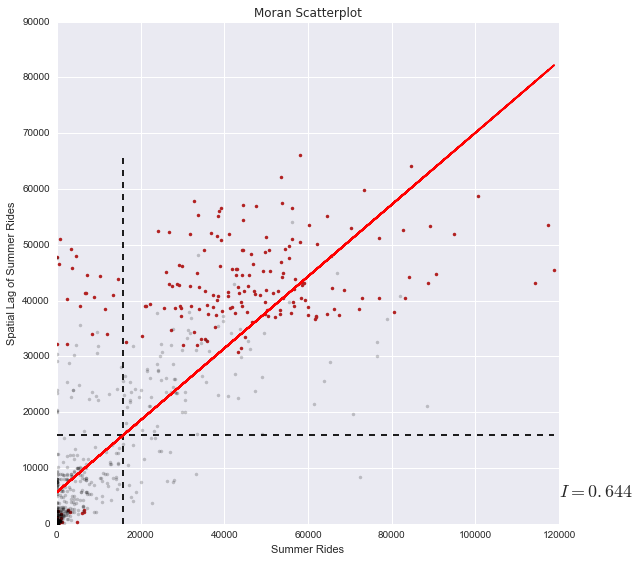

In [87]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

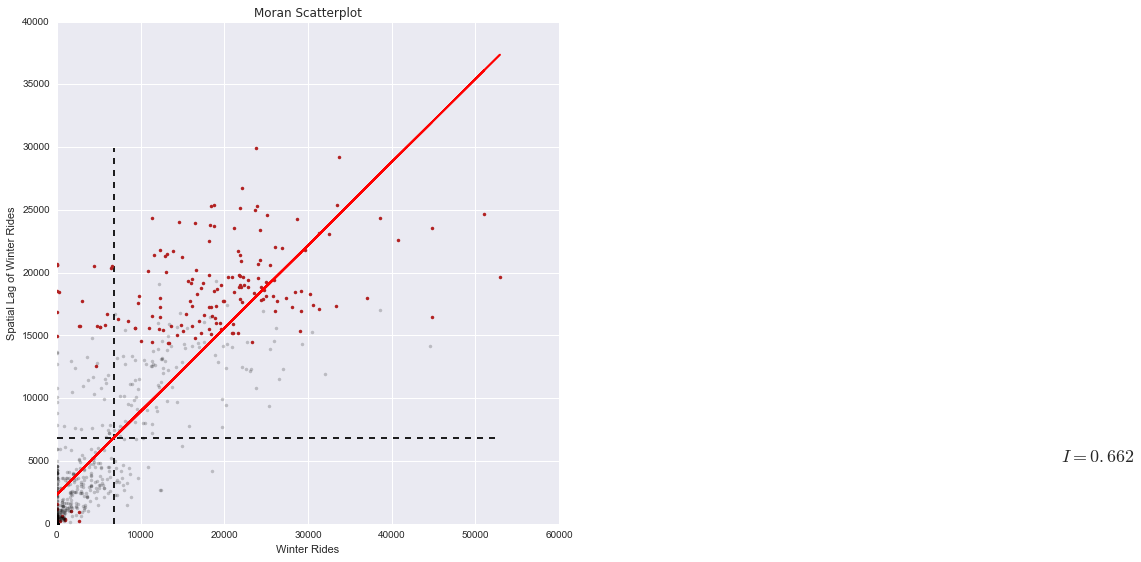

In [88]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigsw, W_sigsw, '.', color='firebrick')
plt.plot(insigsw, W_insigsw, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, aw + bw*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

### Hot and Cold spots 

In [89]:
sig = LMo_SummerRide.p_sim < 0.01
hotspots = LMo_SummerRide.q==1 * sig
coldspots = LMo_SummerRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 189
Number of Coldspots: 241


In [90]:
sigw = LMo_WinterRide.p_sim < 0.01
hotspotsw = LMo_WinterRide.q==1 * sigw
coldspotsw = LMo_WinterRide.q==3 * sigw
print "Number of Hotspots:", hotspotsw.sum()
print "Number of Coldspots:", coldspotsw.sum()

Number of Hotspots: 194
Number of Coldspots: 208


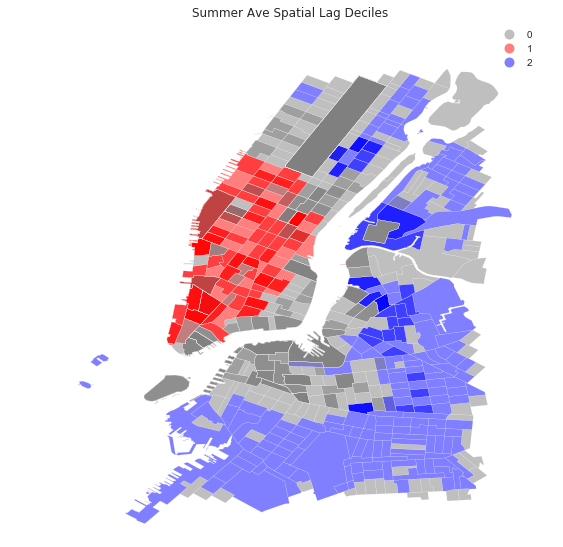

In [91]:
from matplotlib import colors

#tie boolean values to 1 and 2
#add them up and get 0, 1, and 2
#is there a relationship between citibike rides and geography
#red is autocorrelated, they are related to one another
#high number of rides are red and low numbers are blue
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_SummerAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ave Spatial Lag Deciles")

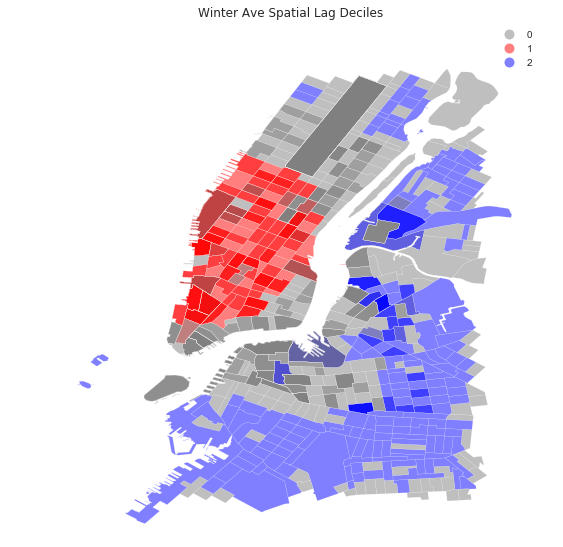

In [92]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspotsw*1 + coldspotsw*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ave Spatial Lag Deciles")